# Longstaff–Schwartz (LSMC) pour le pricing d'un put américain

Objectif du notebook :

- Simuler des trajectoires de sous-jacent $S_t$ sous la mesure risque-neutre.
- Définir un put américain de strike $K$.
- Implémenter l'algorithme de Longstaff–Schwartz :
  - calcul des cashflows futurs,
  - régression pour approximer la valeur de continuation,
  - décision exercice / continuation.
- Comparer le prix américain avec le prix européen sur les mêmes trajectoires.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")


## 1. Modèle sous-jacent : Geometric Brownian Motion (GBM)

On suppose que le sous-jacent suit :

\[
dS_t = (r - q) S_t\, dt + \sigma S_t\, dW_t
\]

sous la mesure risque-neutre.

On discrétise en temps avec un schéma d'Euler exponentiel :

\[
S_{t_{k+1}} = S_{t_k} \exp\left((r - q - \tfrac{1}{2}\sigma^2)\Delta t + \sigma \sqrt{\Delta t}\, Z_k\right)
\]

avec $Z_k \sim \mathcal{N}(0,1)$ i.i.d.


In [2]:
def simulate_gbm_paths(S0, r, q, sigma, T, n_steps, n_paths, seed=None):
    """
    Simule des trajectoires de GBM sous Q.

    Retourne:
        times: array shape (n_steps+1,)
        paths: array shape (n_steps+1, n_paths)
    """
    if seed is not None:
        np.random.seed(seed)

    dt = T / n_steps
    times = np.linspace(0, T, n_steps + 1)

    # Matrice des increments gaussiens
    Z = np.random.normal(size=(n_steps, n_paths))

    # Pré-allocation
    paths = np.zeros((n_steps + 1, n_paths))
    paths[0, :] = S0

    drift = (r - q - 0.5 * sigma**2) * dt
    diff  = sigma * np.sqrt(dt)

    for k in range(n_steps):
        paths[k+1, :] = paths[k, :] * np.exp(drift + diff * Z[k, :])

    return times, paths


In [3]:
# Paramètres du modèle
S0    = 100.0   # spot initial
K     = 100.0   # strike
r     = 0.02    # taux sans risque
q     = 0.0     # dividende
sigma = 0.2     # volatilité
T     = 1.0     # maturité (1 an)

# Discrétisation
n_steps = 50     # nombre de dates de temps
n_paths = 50_000 # nombre de trajectoires

def put_payoff(S):
    """Payoff put européen / américain à une date: (K - S)^+."""
    return np.maximum(K - S, 0.0)


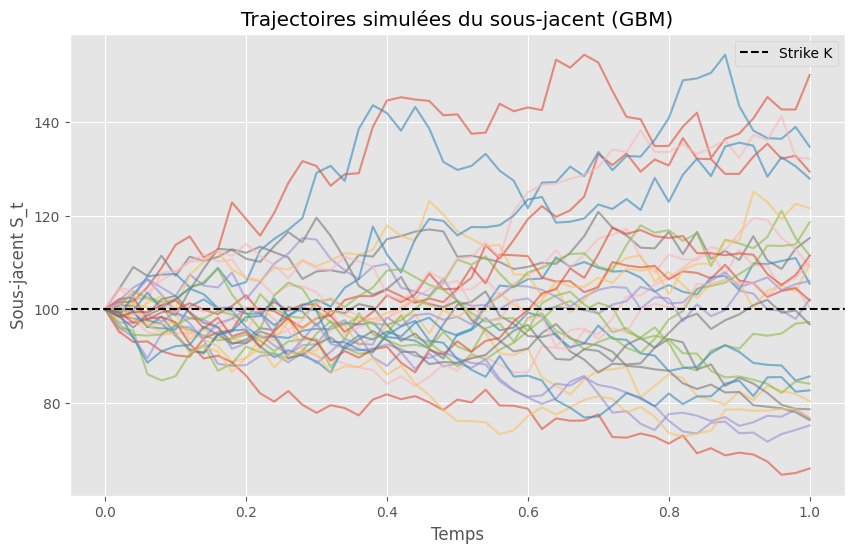

In [4]:
times, paths = simulate_gbm_paths(S0, r, q, sigma, T, n_steps, n_paths, seed=42)

plt.figure(figsize=(10, 6))
for i in range(30):  # affiche quelques trajectoires
    plt.plot(times, paths[:, i], alpha=0.6)
plt.axhline(K, color="black", linestyle="--", label="Strike K")
plt.xlabel("Temps")
plt.ylabel("Sous-jacent S_t")
plt.title("Trajectoires simulées du sous-jacent (GBM)")
plt.legend()
plt.show()


In [5]:
# Prix européen (MC simple) : E[e^{-rT} (K - S_T)^+]
payoff_T = put_payoff(paths[-1, :])
disc_factor = np.exp(-r * T)
price_european_mc = disc_factor * payoff_T.mean()

print(f"Prix put européen (Monte Carlo plain vanilla): {price_european_mc:.4f}")


Prix put européen (Monte Carlo plain vanilla): 6.9529


## 2. Intuition de l'algorithme de Longstaff–Schwartz

Pour un put américain, à chaque date $ t_i $, le détenteur compare :

- **Exercice immédiat**: $ Y_i = (K - S_{t_i})^+ $
- **Valeur de continuation**: 
  \
  C_i = \mathbb{E}\left[ e^{-r \Delta t} V_{i+1} \mid \mathcal{F}_{t_i} \right].
  \

On n'a pas l'espérance analytique, donc on l'approche par une **régression** :

- On a des trajectoires simulées,
- On connaît les cashflows futurs (en partant de la maturité et en remontant),
- On régressse ces cashflows futurs actualisés sur des fonctions de base de $ S_{t_i} $
  (typiquement : 1, $S$, $S^2$, ...).

Algorithme (version simple):

1. À maturité $T$ : $ V_T = Y_T $.
2. Pour $ i = n-1, ..., 1 $ :
   - Sur les trajectoires **in the money** ($Y_i > 0$) :
     - on régressse les cashflows futurs actualisés sur un polynôme en $ S_{t_i} $, 
     - on obtient une approximation de la continuation $ \hat{C}_i(S_{t_i}) $.
   - Sur chaque trajectoire :
     - si $Y_i > \hat{C}_i$, on exerce : $ V_i = Y_i $ (et on met à 0 les cashflows futurs sur cette trajectoire),
     - sinon on continue : $ V_i = e^{-r\Delta t} V_{i+1} $.
3. Au temps 0, $ \text{Prix} = \frac{1}{N} \sum_j V_0^{(j)} $.


In [6]:
def longstaff_schwartz_american_put(paths, r, T, K, basis_degree=2):
    """
    Pricing d'un put américain par Longstaff–Schwartz.

    paths : array (n_steps+1, n_paths) de sous-jacent simulé (GBM).
    r     : taux sans risque
    T     : maturité
    K     : strike
    basis_degree : degré max du polynôme utilisé dans la régression (ex: 2 => [1, S, S^2])

    Retourne:
        price_am : prix estimé du put américain
        V : matrice des valeurs 'option' par pas de temps et par trajectoire
    """
    n_steps, n_paths = paths.shape[0] - 1, paths.shape[1]
    dt = T / n_steps
    disc = np.exp(-r * dt)

    # Payoff immédiat à chaque date
    Y = put_payoff(paths)  # shape (n_steps+1, n_paths)

    # V stocke la valeur de l'option sur chaque trajectoire à chaque date
    V = np.zeros_like(Y)
    V[-1, :] = Y[-1, :]  # à maturité : american = european = payoff

    # On remonte dans le temps
    for t in range(n_steps - 1, 0, -1):
        S_t = paths[t, :]
        Y_t = Y[t, :]

        # Cashflows futurs (déjà déterminés) actualisés 1 pas de temps
        CF_future = V[t+1, :] * disc

        # On ne régressse que sur les paths ITM (put in the money : Y_t > 0)
        itm = Y_t > 0
        if np.sum(itm) > basis_degree + 1:
            # Construire la matrice de base [1, S, S^2, ...]
            X_reg = np.vstack([S_t[itm]**k for k in range(basis_degree + 1)]).T
            Y_reg = CF_future[itm]

            # Régression linéaire OLS: beta = (X^T X)^(-1) X^T Y
            beta, *_ = np.linalg.lstsq(X_reg, Y_reg, rcond=None)

            # Estimation de la continuation sur toutes les trajectoires
            X_all = np.vstack([S_t**k for k in range(basis_degree + 1)]).T
            C_hat = X_all @ beta
        else:
            # S'il n'y a presque pas de points ITM, on approxime continuation = 0
            C_hat = np.zeros_like(S_t)

        # Décision exercice / continuation
        exercise = (Y_t > C_hat)  # booléen par trajectoire

        # Si on exerce: V_t = Y_t, sinon V_t = CF_future
        V[t, exercise]  = Y_t[exercise]
        V[t, ~exercise] = CF_future[~exercise]

    # Au temps 0 : on actualise une fois de plus
    CF_0 = V[1, :] * disc  # cashflows à t=dt actualisés à t=0
    price_am = CF_0.mean()

    return price_am, V


In [7]:
price_amer, V_ls = longstaff_schwartz_american_put(paths, r, T, K, basis_degree=2)

print(f"Prix put américain (Longstaff–Schwartz): {price_amer:.4f}")
print(f"Prix put européen (MC simple)          : {price_european_mc:.4f}")
print(f"Prime américaine (American - European) : {price_amer - price_european_mc:.4f}")


Prix put américain (Longstaff–Schwartz): 5.4253
Prix put européen (MC simple)          : 6.9529
Prime américaine (American - European) : -1.5276


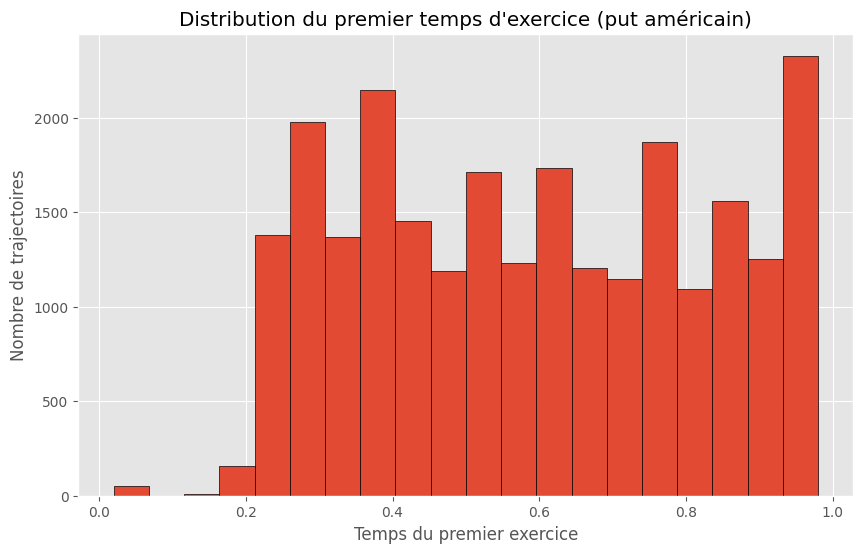

In [8]:
# On reconstruit une "matrice d'exercice" : 1 si exercé à t sur path j, 0 sinon
# On dit qu'on exerce à t si V[t, j] == payoff_t (Y[t, j]) et que V[t+1, j] != V[t, j]*e^{-r dt}

n_steps = paths.shape[0] - 1
n_paths = paths.shape[1]
dt = T / n_steps
disc = np.exp(-r * dt)

exercise_mat = np.zeros_like(V_ls, dtype=bool)

for t in range(1, n_steps):  # on ignore t=0 et T
    S_t = paths[t, :]
    Y_t = put_payoff(S_t)
    CF_future = V_ls[t+1, :] * disc

    # Exercice si V==Y_t et V != CF_future
    exercise_mat[t, :] = (np.abs(V_ls[t, :] - Y_t) < 1e-10) &                          (np.abs(V_ls[t, :] - CF_future) > 1e-10)

# On récupère pour chaque path le premier temps d'exercice (s'il existe)
first_ex_time = np.full(n_paths, np.nan)

for j in range(n_paths):
    exercise_indices = np.where(exercise_mat[:, j])[0]
    if len(exercise_indices) > 0:
        first_ex_time[j] = times[exercise_indices[0]]

plt.figure(figsize=(10, 6))
plt.hist(first_ex_time[~np.isnan(first_ex_time)], bins=20, edgecolor="k")
plt.xlabel("Temps du premier exercice")
plt.ylabel("Nombre de trajectoires")
plt.title("Distribution du premier temps d'exercice (put américain)")
plt.show()
